In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pyntcloud import PyntCloud

INFO - 2021-12-13 23:14:27,418 - utils - NumExpr defaulting to 8 threads.


Firse, we load the PointCloud model of Venice

In [7]:
venice = o3d.io.read_point_cloud('/Users/liyuxiao/Downloads/venice_dense.ply')

In [8]:
o3d.visualization.draw_geometries([venice])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


Voxel downsampling uses a regular voxel grid to create a uniformly downsampled point cloud from an input point cloud. It is often used as a pre-processing step for many point cloud processing tasks.

In [7]:
venice_down = venice.voxel_down_sample(voxel_size=0.005)

Open3D also supports segmententation of geometric primitives from point clouds using RANSAC. To find the plane with the largest support in the point cloud, we can use segment_plane. 

In [9]:
plane_model, inliers = venice_down.segment_plane(distance_threshold=0.01,
                                         ransac_n=3,
                                         num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a}x + {b}y + {c}z + {d} = 0")

Plane equation: -4.857390469157551e-05x + 0.00041414853004545456y + 0.9999999130607816z + 0.16785353820670745 = 0


In [10]:
inlier_cloud = venice_down.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = venice_down.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


statistical_outlier_removal removes points that are further away from their neighbors compared to the average for the point cloud.

In [11]:
venice_down, ind = venice_down.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)

Remove statistical outliers: [========================================] 100%


In [12]:
venice_coordinate = np.asarray(venice_down.points)
print('coordinates of points:')
print(venice_coordinate)
print('total number of points:')
len(venice_coordinate)

coordinates of points:
[[-9.57123820e+02  8.13843397e+02  1.33499533e+01]
 [ 1.13942098e+03  2.34880467e+00 -8.56079018e-01]
 [-4.17225781e+02 -1.71474415e+03  1.75854950e-01]
 ...
 [-1.64611308e+00 -2.48737811e+03 -5.09643833e-02]
 [ 2.29241501e+03 -3.61722243e+02  6.10928014e-01]
 [-6.30261240e+01 -1.66090909e+03 -9.81963032e-03]]
total number of points:


1428660

Select point to check height

In [13]:
def pick_points(venice):
    print("")
    print(
        "1) Please pick at least three correspondences using [shift + left click]"
    )
    print("   Press [shift + right click] to undo point picking")
    print("2) Afther picking points, press q for close the window")
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(venice)
    vis.run()  # user picks points
    vis.destroy_window()
    print("")
    return vis.get_picked_points()

In [ ]:
pick_points(venice_down)

In [30]:
venice_color = np.asarray(venice_down.colors)

PointCloud with 1456983 points.

This step we try to rotate the PointCloud so that the plane in the PointCloud is XoY plane

In [17]:
    cos = c
    sin = np.sqrt(a**2+b**2)
    u1= b
    u2= -a
    R = [[cos+u1**2*(1-cos), u1*u2*(1-cos), u2*sin],
    [u1*u2*(1-cos),cos+u2**2*(1-cos),-u1*sin],
    [-u2*sin, u1*sin, cos]]
    venice_down.rotate(R, center=venice_down.get_center())
    plane_model, inliers = venice_down.segment_plane(distance_threshold=0.01,
                                         ransac_n=3,
                                         num_iterations=1000)
    [a, b, c, d] = plane_model
    venice_down = venice_down.translate((0, 0, d))
    print(f"Plane equation: {a}x + {b}y + {c}z + {d} = 0")

Plane equation: 4.605012901227473e-05x + 0.00034446393347886694y + 0.9999999396119902z + 0.06132459911454325 = 0


Calculate the distance

In [ ]:
venice_coordinate = np.asarray(venice_down.points)
distance = np.zeros((len(venice_coordinate),1))
for i in range(len(venice_coordinate)):
    distance[i] = abs(venice_coordinate[i,0]*a+ venice_coordinate[i,1]*b+ venice_coordinate[i,2]*c +d)/np.sqrt(a**2+b**2+c**2)

Scale the model

In [18]:
    venice_down.scale(98.6/distance[np.argmax(distance, axis=0)][0,0], center=venice_down.get_center())

PointCloud with 1428660 points.

Z coordinate of the height point in Venice: (reference:98.6m)

In [20]:
venice_coordinate[np.argmax(distance, axis=0)][0,2]

98.65215074338035

Distance from the height ppoint to the ground:

In [21]:
distance[np.argmax(distance, axis=0)][0,0]

98.58175978842436

Save the model

In [66]:
o3d.io.write_point_cloud("/Users/liyuxiao/Downloads/real_venice_2.ply", venice_down)

True

In [6]:
cloud = PyntCloud.from_file("/Users/liyuxiao/Downloads/real_venice_2.ply")

In [7]:
cloud.points.describe()

x             y             z            nx            ny  \
count  1.456983e+06  1.456983e+06  1.456983e+06  1.456983e+06  1.456983e+06   
mean   1.499217e+00  1.645440e+00  5.321491e+00  3.691426e-03 -6.899281e-03   
std    1.235645e+03  1.384349e+03  7.454962e+00  2.632399e-01  2.799578e-01   
min   -3.090319e+03 -3.331431e+03 -1.945718e+01 -9.239043e-01 -9.464624e-01   
25%   -8.970768e+02 -1.113645e+03 -1.117462e-01 -8.927667e-02 -1.157005e-01   
50%   -3.080773e+01  7.063059e+01  1.356383e+00 -1.108559e-03 -2.845366e-03   
75%    8.853088e+02  1.066805e+03  1.102760e+01  9.964615e-02  9.946486e-02   
max    3.351728e+03  3.399355e+03  9.882381e+01  9.243402e-01  9.465018e-01   

                 nz           red         green          blue  
count  1.456983e+06  1.456983e+06  1.456983e+06  1.456983e+06  
mean   6.983640e-01  1.565211e+01  1.565211e+01  1.565211e+01  
std    2.987712e-01  1.802541e+01  1.802541e+01  1.802541e+01  
min   -9.429427e-01  0.000000e+00  0.000000e+00  0.000000e+00  
25%    5.975469e-01  1.000000e+00  1.000000e+00  1.000000e+00  
50%    8.216159e-01  6.000000e+00  6.000000e+00  6.000000e+00  
75%    9.099956e-01  2.900000e+01  2.900000e+01  2.900000e+01  
max    9.465037e-01  2.550000e+02  2.550000e+02  2.550000e+02

In [8]:
pointframe = cloud.points
pointframe

x            y          z        nx        ny        nz  \
0        -957.123820   813.843397  13.349953 -0.071604 -0.103514  0.695782   
1        1139.420983     2.348805  -0.856079 -0.366974  0.534549  0.513885   
2        -417.225781 -1714.744148   0.175855  0.032128  0.060775  0.764975   
3       -2054.548432   298.212533  20.762901 -0.229483  0.376444  0.800466   
4        -943.522487  2053.324164   1.663211 -0.042070 -0.039123  0.933560   
...              ...          ...        ...       ...       ...       ...   
1456978   959.330401 -2108.588224  19.576178  0.171933 -0.279450  0.824632   
1456979  2279.976663 -1568.739931  -0.556765 -0.006747 -0.003247  0.944931   
1456980    -1.646113 -2487.378106  -0.050964 -0.263295  0.489307 -0.071095   
1456981  2292.415011  -361.722243   0.610928 -0.047070 -0.426839  0.829446   
1456982   -63.026124 -1660.909094  -0.009820 -0.077900  0.003193  0.872545   

         red  green  blue  
0         36     36    36  
1          2      2     2  
2          1      1     1  
3         54     54    54  
4          7      7     7  
...      ...    ...   ...  
1456978   49     49    49  
1456979    2      2     2  
1456980    2      2     2  
1456981    2      2     2  
1456982    1      1     1  

[1456983 rows x 9 columns]

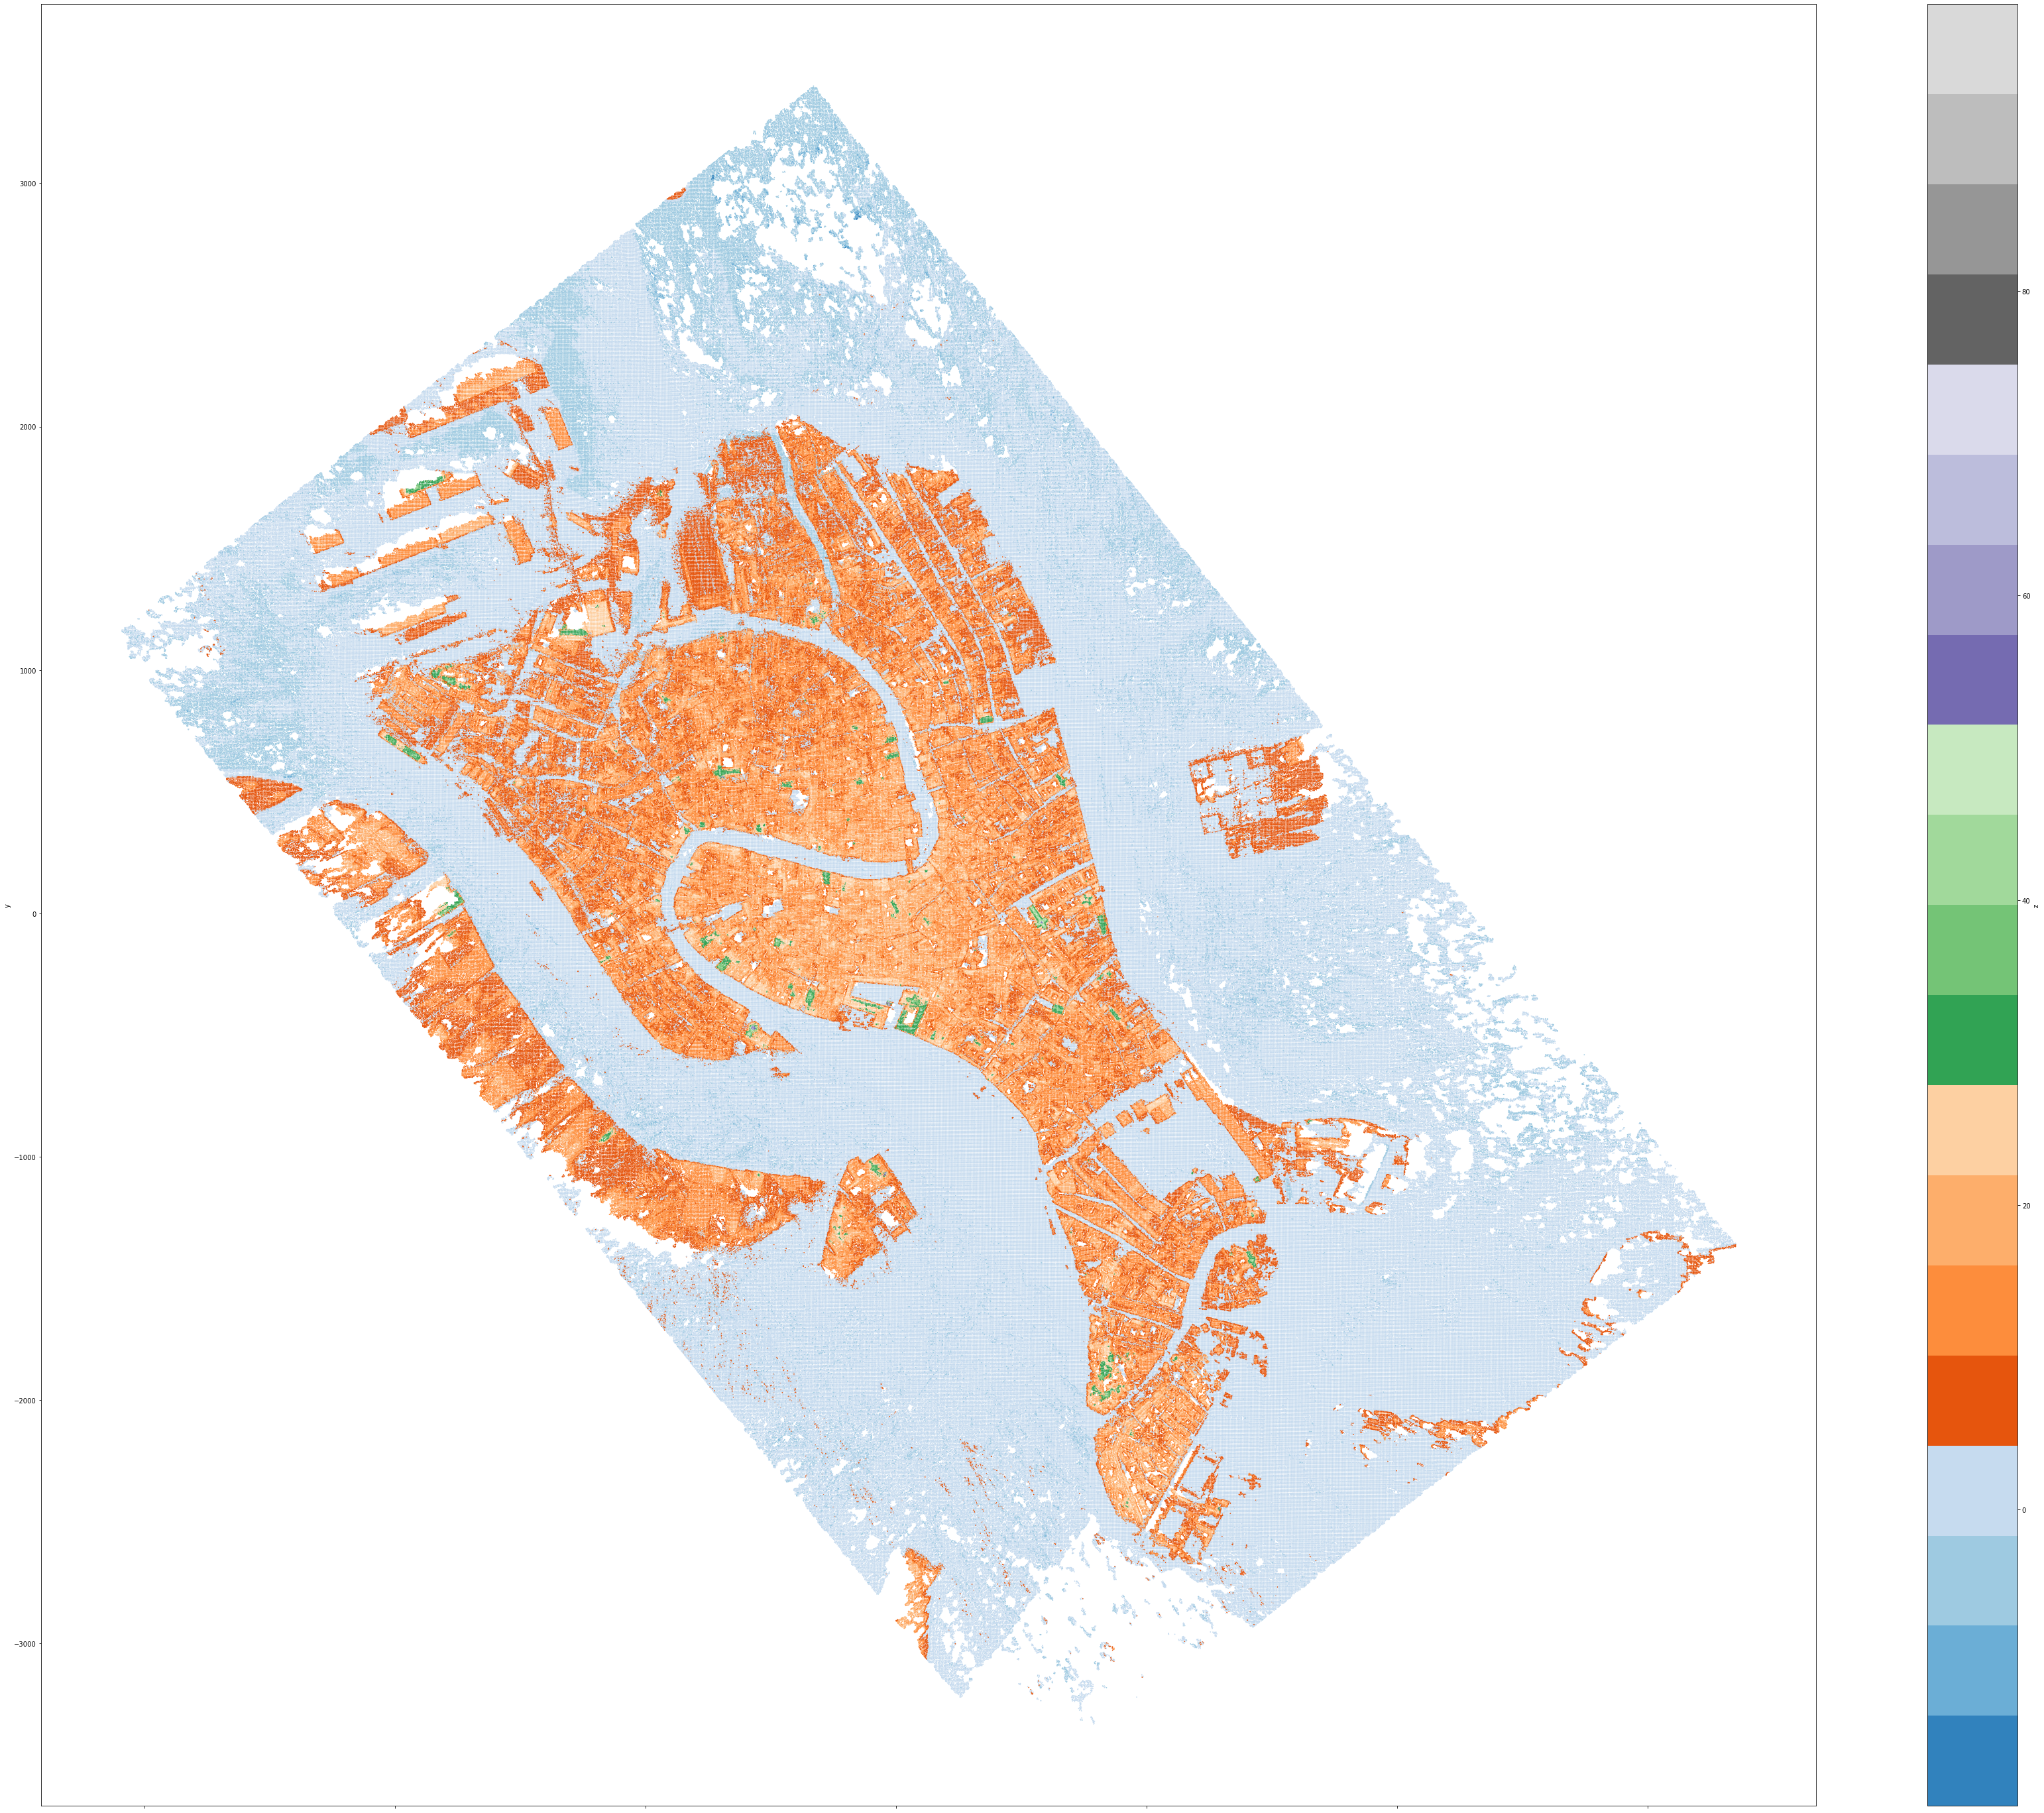

In [20]:
pointframe.plot.scatter(x="x", y="y", c="z", s=0.5, cmap="tab20c",figsize=(60,50))
plt.show()


distance calculation and Normalize the distance

In [ ]:
distance = np.zeros((len(venice_coordinate),1))
for i in range(len(venice_coordinate)):
    distance[i] = abs(venice_coordinate[i,0]*a+ venice_coordinate[i,1]*b+ venice_coordinate[i,2]*c +d)/np.sqrt(a**2+b**2+c**2)
distance = distance/np.max(np.max(distance))
distance = np.hstack((distance,distance,distance))

In [ ]:
venice_down.colors = o3d.utility.Vector3dVector(distance)
o3d.visualization.draw_geometries([venice_down])

In [ ]:
venice_color = np.asarray(venice_down.colors)